# Implement a custom Autoencoder with Koopman layer

## Version Control

Short Term To Do:
1) Consider output activation function to be more robust than
2) Plot eigenfunctions & save
3) Constraining K

Long Term To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
3) Preprocess Data
4) Make sure sim data is different for different ground parameters
7) Change training inference vs testing inference

Note:
If you see a warning with koopman weight has no graident: reinitialize the model class object and run training directly. Do not build it before training.


## Setup

In [185]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time 
import os

In [139]:
# Import hyperparameter tuning
import keras_tuner as kt
hp = kt.HyperParameters()

In [100]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [101]:
#from google.colab import drive
#drive.mount('/gdrive')

## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [102]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',', header=None).values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',', header=None).values
discrete_validation = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',', header=None).values

In [103]:
print(np.shape(discrete_train))
print(np.shape(discrete_validation))

(65536, 2)
(65536, 2)


In [104]:
trajLength = int(2^6) #length of each trajectory in the dataset
numTraj = int(2^10) #total number of trajectories in the dataset

batch_size = int(512)
numTraj_batch = int(batch_size/trajLength)

num_batches = int(batch_size/trajLength)
input_dim = 2

In [105]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_validation = (discrete_validation - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)


train_data = tf.cast(discrete_train, tf.float32)
validation_data = tf.cast(discrete_validation, tf.float32)
test_data = tf.cast(discrete_test, tf.float32)


In [106]:
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)

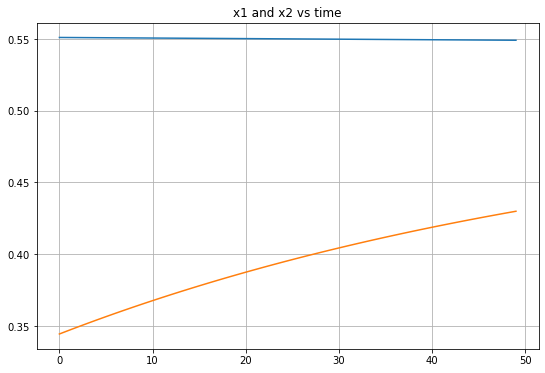

In [107]:
x_train = train_data[0:50,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

## Define the model

### Encoder

In [108]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None, act='None'):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [156]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder to take to lifted dimension w/ one output
    """
    def __init__(self, hp, name=None):
        """
        Initializes arbritrary layers of different unit size for encoder
        
        Parameter:
        ----------
        hp: Hyperparameter from keras
        name: String
            name of model
        """
        super(EncoderModel, self).__init__(name=name)
        self.encLayerLength = hp.Int("encLayerLength", min_value=3, max_value=5, step=1)
        self.encLayerDict = {}
        self.encActDict = {}
        for i in range(self.encLayerLength):
            self.encLayerDict["encLayer" + str(i)] = EncoderLayer(hp.Choice("enc_units_"+str(i),[16, 32, 64]))
            self.encActDict["encActLayer" + str(i)] = tf.keras.layers.Activation(hp.Choice("enc_act_"+str(i),['relu','elu']))
                                                        

    def call(self, input):
        z = input # Final layer of encoder is in lifted dimension
        for (key1,enc),(key2,act) in zip(self.encLayerDict.items(), self.encActDict.items()):
            z = enc(z)
            z = act(z)
        
        return z

### Koopman

In [110]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 indices = tf.constant([[traj*self.trajLength]])
                 if m == 0: 
                     updates = [tf.linalg.matvec(self.K, z1[0,:])]
                     tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    updates = [tf.linalg.matvec(tf.matmul(self.K,self.K), z1[traj,:])]
                    tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                    
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(Z2-Z2_tilde))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))

        return Z, Z2_tilde

In [111]:
class KoopmanModel(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    K: tensor
        Koopman operator in the lifted space
    """
    
    def __init__(self, trajLength, numTraj , name=None, act='None'):
        super(KoopmanModel, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj)


    def call(self, input):
        z = input
        z, z2_tilde = self.koopman(z)
        return z, z2_tilde

### Decoder

In [112]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b

In [226]:
class DecoderModel(keras.Model):
    """
    Custom Model to create an decoder w/ two outputs
    """
    def __init__(self, hp, outputDim=2, name=None):
        """
        Initializes arbritrary layers of different unit size
        
        Parameter:
        ----------
        hp: Hyperparameter from keras
        name: String
            name of model
        """
        super(DecoderModel, self).__init__(name=name)
        self.decLayerLength = hp.Int("decLayerLength", min_value=3, max_value=5, step=1)
        self.decLayerDict = {}
        self.decActDict = {}
        for i in range(self.decLayerLength):
            self.decLayerDict["decLayer" + str(i)] = DecoderLayer(hp.Choice("dec_units_"+str(i),[16, 32, 64]))
            self.decActDict["decActLayer" + str(i)] = tf.keras.layers.Activation(hp.Choice("dec_act_"+str(i),['relu','elu']))

        self.outputLayer = DecoderLayer(outputDim, name="dec_output_layer") # Specify output dimension

    def call(self, z, z2_tilde):
        x_hat = z # Input for reconstruction
        x2_hat = z2_tilde
        for (key1,dec),(key2,act) in zip(self.decLayerDict.items(), self.decActDict.items()):
            x_hat, x2_hat = dec(x_hat, x2_hat)
            x_hat = act(x_hat)
            x2_hat = act(x2_hat)
        x_hat, x2_hat = self.outputLayer(x_hat,x2_hat)
        x_hat = tf.nn.sigmoid(x_hat)
        x2_hat = tf.nn.sigmoid(x2_hat)
        return x_hat, x2_hat

### Koopman Autoencoder

In [231]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create an autoencoder class w/ Analytical Koopman Operator layer
    """
    def __init__(self, hp, trajLength, numTraj, outputDim, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel(hp)
        self.koopman = KoopmanModel(trajLength, numTraj)
        self.dec = DecoderModel(hp, outputDim=outputDim)
    

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_tilde = self.koopman(z)
        x_hat, x2_hat = self.dec(z, z2_tilde)
        return x_hat, x2_hat  

## Hyperparameter Tuning

In [232]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, input_dim, batch_size, trajLength):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj = int(self.batch_size/self.trajLength) # should be int
        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 


    def build(self, hp):
        koopmanAEModel = Koopman_AE_Model(hp, self.trajLength, self.numtraj, 2, name="Koopman_AE_Model")
        return koopmanAEModel




    def recon_loss(self, x, x_hat):
        """Calculates reconstruction loss from input x to output x_hat"""
        return tf.reduce_mean(tf.abs(x-x_hat)) #avg loss for each batch since reduce_mean is already an avg

    def predict_loss(self, x, x2_hat):
        """Calculates prediction loss from x2 (time shifted x) to output x2_hat"""
        x2 = []
        for i in range(self.numtraj):
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength])
        x2 = tf.reshape(x2, [-1, x_train.shape[-1]])
        return tf.reduce_mean(tf.abs(x2-x2_hat)) #avg loss for each batch since reduce_mean is already an av
    
    def l2_loss(self, model):
        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights 
                            if 'bias' not in w.name])
        return lossL2

    def tot_loss(self, model, recon_loss, predict_loss):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        alpha1 = 0.1
        #alpha2 = 1e-7
        alpha3 = 1e-15
        return alpha1 * (recon_loss + predict_loss) + sum(model.losses) + alpha3 * self.l2_loss(model)


    def graphPlot(self, error):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error)
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        if saveFiles:
            plt.savefig(imgPath+textTitle+'png', bbox_inches='tight') 



    def fit(self, hp, model, x, y, validation_data, batch_size, callbacks=None):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define weights that are trainable
        variables = model.trainable_variables

        # Define the optimizer
        optimizer = tf.keras.optimizers.SGD(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3))

        # Metric to track validation loss
        epoch_loss_metric = keras.metrics.Mean()
        epochs = 50

        def run_train_step(x_batch_train,y_batch_train):
            with tf.GradientTape() as tape:
                #batch_length =  len(x_batch_train) #num elements in each batch
                reconstruction, prediction = model(x_batch_train)
            
                # avg loss for each batch
                recon_loss =  self.recon_loss(y_batch_train, reconstruction)
                predict_loss =  self.predict_loss(y_batch_train, prediction)

                # total avg loss for each batch
                batch_train_loss = self.tot_loss(model, recon_loss, predict_loss)
                batch_train_loss_list.append(batch_train_loss)

            grads = tape.gradient(batch_train_loss, variables)
            optimizer.apply_gradients(zip(grads, variables))
            return batch_train_loss

        def run_val_step(x_batch_val,y_batch_val):
            reconstruction_val, pred_val = model(x_batch_val)
            recon_loss_val = self.recon_loss(y_batch_val, reconstruction_val)
            predict_loss_val =  self.predict_loss(y_batch_val, pred_val)
            batch_validation_loss = self.tot_loss(model, recon_loss_val, predict_loss_val)

            batch_validation_loss_list.append(batch_validation_loss)

            epoch_loss_metric.update_state(batch_validation_loss)
            return batch_validation_loss
        
        for callback in callbacks:
            callback.model = model
        
        best_epoch_val_loss = float("inf")
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []
            
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                batch_train_loss = run_train_step(x_batch_train, y_batch_train)
                
                # Log every 100 batches.
                if step % 100 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(batch_train_loss))
                    )
                    print("Seen so far: %s samples" % ((step + 1) * batch_size))
            
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/num_batches
            epoch_train_loss.append(avg_train_loss)

            print(
                    "Average training loss at epoch %d: %.4f"
                    % (epoch, float(avg_train_loss))
                )
            print("Time taken: %.2fs" % (time.time() - start_time))

        
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                batch_validation_loss = run_val_step(x_batch_val, y_batch_val)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/num_batches)

            # Calling the callbacks after epoch
            epoch_loss_val = float(epoch_loss_metric.result().numpy())
            
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner
                callback.on_epoch_end(epoch, logs={"my_metric": epoch_loss_val})
            epoch_loss_metric.reset_states()

            print(f"Epoch val loss: {epoch_loss_val}")
            print("Time taken: %.2fs" % (time.time() - start_time))
            best_epoch_val_loss = min(best_epoch_val_loss, epoch_loss_val)
        self.graphPlot(epoch_train_loss)
        # Return the evaluation metric value
        return best_epoch_val_loss

In [229]:
hypermodel = MyHyperModel(input_dim, batch_size, num_batches)
tuner = kt.RandomSearch(
    objective=kt.Objective("my_metric", "min"),
    max_trials=5,
    hypermodel=hypermodel,
    directory="results",
    project_name="custom_training1",
    overwrite=True,
)

Trial 1 Complete [00h 03m 02s]
my_metric: 0.050864022225141525

Best my_metric So Far: 0.050864022225141525
Total elapsed time: 00h 03m 02s
INFO:tensorflow:Oracle triggered exit


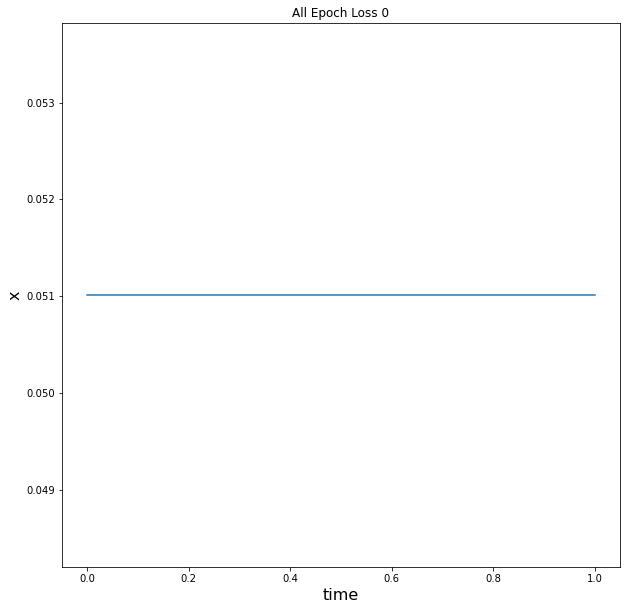

In [230]:
tuner.search(x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)

In [182]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'encLayerLength': 4, 'enc_units_0': 16, 'enc_act_0': 'elu', 'enc_units_1': 64, 'enc_act_1': 'elu', 'enc_units_2': 64, 'enc_act_2': 'elu', 'decLayerLength': 3, 'dec_units_0': 32, 'dec_act_0': 'elu', 'dec_units_1': 64, 'dec_act_1': 'relu', 'dec_units_2': 16, 'dec_act_2': 'elu', 'enc_units_3': 16, 'enc_act_3': 'relu', 'learning_rate': 0.001}


In [184]:
best_model = tuner.get_best_models()[0]
out1, out2 = best_model(train_data)
best_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  6336      
_________________________________________________________________
koopman_model (KoopmanModel) multiple                  256       
_________________________________________________________________
decoder_model (DecoderModel) multiple                  3730      
Total params: 10,322
Trainable params: 10,322
Non-trainable params: 0
_________________________________________________________________


# Plots

Text(0.5, 1.0, 'Ground Truth Data')

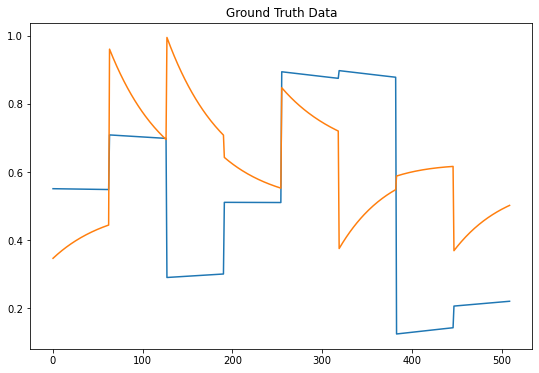

In [ ]:
input = x_train[0:510]
plt.plot(input)
plt.title("Ground Truth Data")

Text(0.5, 1.0, 'Koopman AE Output')

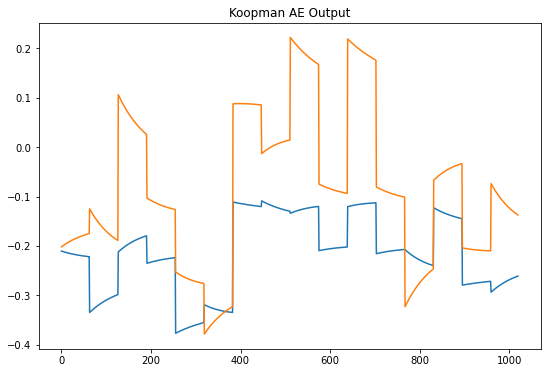

In [ ]:
plt.plot(out1)
plt.title("Koopman AE Output")

In [ ]:
best_model.save('checkpoints/test_koopman_1')

INFO:tensorflow:Assets written to: checkpoints/test_koopman_1\assets


Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  1168      
_________________________________________________________________
koopman_layer (KoopmanLayer) multiple                  0         
_________________________________________________________________
decoder_model (DecoderModel) multiple                  4802      
Total params: 5,970
Trainable params: 5,970
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'New Model Koopman AE Output')

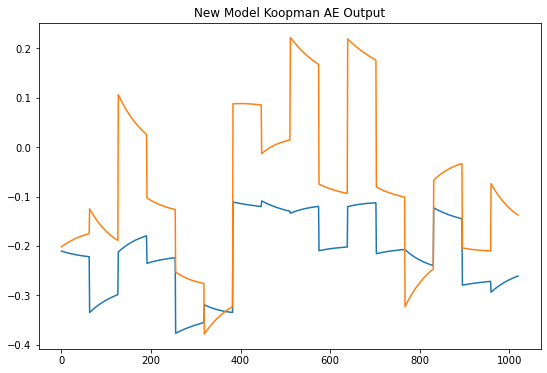

In [ ]:
new_model = tf.keras.models.load_model('checkpoints/test_koopman_1', compile=False)
new_model.summary()
new_out1, new_out2 = new_model(x_train)
plt.plot(new_out1)
plt.title("New Model Koopman AE Output")

In [ ]:
new_model.koopmanLayer.get_weights

<bound method Layer.get_weights of <keras.saving.saved_model.load.KoopmanLayer object at 0x000001D6491A17C0>>